# CSX46 Class Session 18: Markov Clustering

In today's notebook we will analyze a small network described in a text file that is in an edge-list format called `dot` (the `dot` file format originated with, and is used by, the GraphViz command-line toolset for graph visualization, which can be accessed from python using the `pygraphviz` python package). We will implement a Markov clustering algorithm and run it on the small test graph. Then we will run Markov Clustering on the human protein-protein interaction network and histogram the sizes of the resulting clusters.

We are going to need to install the PyPI package `pygraphviz`, which requires first installing the Linux packages `graphviz` and `libgraphviz-dev`.

In [ ]:
!apt-get install -y graphviz libgraphviz-dev
!pip install pygraphviz
import pygraphviz

Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.42.2-3build2).
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common libgvc6-plugins-gtk libxdot4
0 upgraded, 8 newly installed, 0 to remove and 22 not upgraded.
Need to get 2,148 kB of archives.
After this operation, 7,427 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/main amd64 libgtk2.0-common all 2.24.32-4ubuntu4 [126 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/main amd64 libgtk2.0-0 amd64 2.24.32-4ubuntu4 [1,791 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal/main amd64 libgail18 amd64 2.24.32-4ubuntu4 [14.7 kB]
Get:4 http://archive.ubuntu.com

Now install `pycairo` and `igraph`.

In [ ]:
!apt-get install libcairo2-dev libjpeg-dev libgif-dev
!pip install pycairo
import cairo
! pip install python-igraph
import igraph

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgif-dev is already the newest version (5.1.9-1).
libgif-dev set to manually installed.
libjpeg-dev is already the newest version (8c-2ubuntu8).
libjpeg-dev set to manually installed.
The following additional packages will be installed:
  libblkid-dev libcairo-script-interpreter2 libffi-dev libglib2.0-dev
  libglib2.0-dev-bin liblzo2-2 libmount-dev libpixman-1-dev libselinux1-dev
  libsepol1-dev libxcb-render0-dev libxcb-shm0-dev
Suggested packages:
  libcairo2-doc libgirepository1.0-dev libglib2.0-doc libgdk-pixbuf2.0-bin
  | libgdk-pixbuf2.0-dev libxml2-utils
The following NEW packages will be installed:
  libblkid-dev libcairo-script-interpreter2 libcairo2-dev libffi-dev
  libglib2.0-dev libglib2.0-dev-bin liblzo2-2 libmount-dev libpixman-1-dev
  libselinux1-dev libsepol1-dev libxcb-render0-dev libxcb-shm0-dev
0 upgraded, 13 newly installed, 0 to remove and 22 not upgraded.
Need to get 

Now install all the other data sciencey kinds of packages that we will need (`pandas`, `matplotlib.pyplot`, `numpy`, `collections`, and `csv`).

In [ ]:
import numpy as np
import pandas as pd
import csv, collections
import matplotlib.pyplot as plt

Download the URL https://csx46.s3-us-west-2.amazonaws.com/markov-clustering-test-network.dot to the file `markov-clustering-test-network.dot`

In [ ]:
!curl https://csx46.s3-us-west-2.amazonaws.com/markov-clustering-test-network.dot > markov-clustering-test-network.dot

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   195  100   195    0     0    270      0 --:--:-- --:--:-- --:--:--   269


View the file that we just downloaded, usint the shell command `cat`. You can see that it is basically an edge-list description of an undirected graph, with the field separator `--` and with the semicolon character as the record separator.

In [ ]:
!cat markov-clustering-test-network.dot

graph graphwcluster {
1--2;
1--6;
1--7;
2--7;
6--7;
2--4;
2--3;
3--6;
3--4;
3--7;
4--7;
4--5;
4--6;
5--7;
5--6;
5--8;
8--9;
9--10;
9--12;
9--13;
10--11;
10--12;
10--13;
11--12;
11--13;
12--13;
}


Use the static clsas method `pygrahpviz.AGraph` to load the file `markov-clustering-test-network.dot` and return an object of class `pygraphviz.agraph.AGraph` containing an undirected graph.

In [ ]:
test_graph = pygraphviz.AGraph("markov-clustering-test-network.dot")
type(test_graph)

pygraphviz.agraph.AGraph

Get the set of edges (as a list of pairlists) using the `pygraphviz.agraph.AGraph.edges()` method

In [ ]:
edges = test_graph.edges()
edges[0:5]

[('1', '2'), ('1', '6'), ('1', '7'), ('2', '7'), ('2', '4')]

Make an `igraph.Graph` object from the `edges` list using the class method `igraph.Graph.TupleList()`:

In [ ]:
test_igraph = igraph.Graph.TupleList(edges)
test_igraph.summary()

'IGRAPH UN-- 13 26 -- \n+ attr: name (v)'

Draw a plot of the graph using the function `igraph.drawing.plot()`. Use the `igraph.Graph.vs()` to get a VertexSet and index into it using `name`; that will give you a list of vertex names to pass to the `plot` function as argument `vertex_label`. How many distinct network communities do you expect to get from Markov clustering?

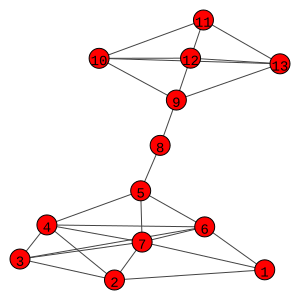

In [ ]:
igraph.drawing.plot(test_igraph, bbox=[0, 0, 300, 300], vertex_label=test_igraph.vs['name'])

Now the fun part. Implement a markov cluster function!

In [ ]:
# define a threshold of 1.0e-10
THRESH = 1.0e-10

def markov_cluster(graph: igraph.Graph):
    # you will need to construct an adjacency matrix; use the get_adjacency() method and then
    # reference the '.data' attribute of the object (of class igraph.datatypes.Matrix)
    # that was returned from `get_adjacency()`.
    adj_mat = np.matrix(graph.get_adjacency().data)

    # need to know the number of vertices; use shape (and indexing to element zero) to get that
    N = adj_mat.shape[0]

    # you will need to compute the vertex degrees and put them in a numpy array
    vertex_degrees = np.array(graph.degree())

    # make a transition matrix in two steps:
    # first, compute the sum of the adjacency matrix and a parity matrix
    #   (the parity matrix can be made using using numpy.diag)
    # second, compute the inverse of the vertex_degrees diagonal matrix using numpy.diag
    #   and numpy.inalg.inv (inverse should always exist b/c we assume the graph is void-free)
    trans_mat_new = (adj_mat + np.diag([1]*N)) * np.linalg.inv(np.diag(vertex_degrees + 1))

    # initialize the "current" transition matrix as a NxN matrix of all zeros,
    # using np.zeros
    trans_mat = np.zeros([N, N])

    # set an iteration counter to zero; we will hard-code a max of 20 iterations below
    iter_count = 0

    # while the fractional change in the transition matrix (by Frobenius norm) is less than 0.01 and
    # iterations is less than 20....

        # note: use numpy.linalg.norm(    , ord="fro"); we are going to compute this norm for the difference
        # _and_ for the average of the current transition matrix and the new transition matrix; compute the ratio

    while ((np.linalg.norm(trans_mat_new - trans_mat, ord="fro")/
            np.linalg.norm(0.5*(trans_mat_new + trans_mat), ord="fro")) > 0.01 and iter_count < 20):

        # assign the the value of `trans_mat_new` to the variable `trans_mat`
        trans_mat = trans_mat_new

        # apply the expansion step with r=2, using numpy.linalg.matrix_power(   , 2)
        trans_mat_new = np.linalg.matrix_power(trans_mat_new, 2)

        # note: trans_mat_new is still a left stochastic matrix (you can check it to be sure)

        # now apply the inflation step with s=2, using numpy.power(  , 2)
        trans_mat_new = np.power(trans_mat_new, 2)

        # compute column sums using numpy.sum(   , axis=0)
        column_sums = np.sum(trans_mat_new, axis=0)

        # make a matrix of the column sums using numpy.repeat(    , N, axis=0); call it trans_mat_div
        trans_mat_div = np.repeat(column_sums, N, axis=0)

        # normalize the inflated matrix by element_wise dividing by trans_mat_div using numpy.divide
        trans_mat_new = np.divide(trans_mat_new, trans_mat_div)

        # increment iter_count
        iter_count += 1

        # print out the iteration counter, as a simple progress indicator
        print("just completed iteration: " + str(iter_count))

    # threshold the transition matrix at 1e-10, into a binary matrix (containing only 0 or 1 in each element)
    trans_mat_new[trans_mat_new < THRESH] = 0.0
    trans_mat_new[trans_mat_new > THRESH] = 1.0

    # take the transpose matrix and make a data frame out of it
    trans_mat_df = pd.DataFrame(trans_mat_new.transpose())

    # each row is a "signature" corresponding to a specific cluster; drop duplicate rows
    cluster_signatures = trans_mat_df.drop_duplicates()

    # count the clusters and assign a numeric cluster ID to each cluster, by
    # setting the `index` variable (use range to get a sequence
    # 1..cluster_signatures.shape[0])
    cluster_signatures.index=range(cluster_signatures.shape[0])

    # use pandas.merge to compute the index for each signature in the original matrix (before you dropped duplicates)
    # - make sure to call reset_index on each of the data frames that you are passing to merge
    # - in the merge call, for the left_on argument, specify the columns of cluster_signatures (list format)
    # - in the marge call, for the right_on argument, specify the columns of trans_mat_df (list_format)
    merged_df = pd.merge(cluster_signatures.reset_index(),
                         trans_mat_df.reset_index(),
                         left_on=cluster_signatures.columns.tolist(),
                         right_on=trans_mat_df.columns.tolist())

    # return the "index_x" column of merged_df, in list format
    return merged_df["index_x"].tolist()


Run your code on test_igraph and print the results!  How many iterations did it take?  

In [ ]:
test_clust_ids = markov_cluster(test_igraph)

just completed iteration: 1
just completed iteration: 2
just completed iteration: 3
just completed iteration: 4
just completed iteration: 5
just completed iteration: 6
just completed iteration: 7
just completed iteration: 8
just completed iteration: 9


Do the clusters make sense?

In [ ]:
tuple(('vertex ' + str(id) + ' has cluster ID: ', cid) for id, cid in enumerate(test_clust_ids))

(('vertex 0 has cluster ID: ', 0),
 ('vertex 1 has cluster ID: ', 0),
 ('vertex 2 has cluster ID: ', 0),
 ('vertex 3 has cluster ID: ', 0),
 ('vertex 4 has cluster ID: ', 0),
 ('vertex 5 has cluster ID: ', 0),
 ('vertex 6 has cluster ID: ', 0),
 ('vertex 7 has cluster ID: ', 1),
 ('vertex 8 has cluster ID: ', 2),
 ('vertex 9 has cluster ID: ', 2),
 ('vertex 10 has cluster ID: ', 2),
 ('vertex 11 has cluster ID: ', 2),
 ('vertex 12 has cluster ID: ', 2))

Now see if you can load in a larger graph (the yeast protein-protein interaction network, obtained from the supplementary data that accompanied the Krogan et&nbsp;al. paper that was in the assigned reading for today's class session) in edge-list (SIF) format. We will download the network from the URL https://csx46.s3-us-west-2.amazonaws.com/krogan-yeast-ppi-network.sif.

In [ ]:
!curl https://csx46.s3-us-west-2.amazonaws.com/krogan-yeast-ppi-network.sif > krogan-yeast-ppi-network.sif

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 75826  100 75826    0     0  70998      0  0:00:01  0:00:01 --:--:-- 70998


Load the file `krogan-yeast-ppi-network.sif` using `pandas.read_csv()`, and assign to a dataframe `df`.

In [ ]:
df = pd.read_csv("krogan-yeast-ppi-network.sif",
                 sep="\t",
                 quoting=csv.QUOTE_NONE,
                 names=["species1","species2"])

As usual, it's a good idea to take a look at the dataframe that you just created, using `pandas.DataFrame.head`.

In [ ]:
df.head()

,species1,species2
0,AAC3,PMR1
1,AAP1,GUD1
2,AAP1,TRS31
3,AAP1,GCN3
4,AAP1,MDY2


Make an igraph graph from the dataframe `df`. As usual, inspect it using `summary`.

In [ ]:
krogan_graph = igraph.Graph.TupleList(df.values.tolist())
krogan_graph.summary()

'IGRAPH UN-- 2674 7079 -- \n+ attr: name (v)'

Run the graph through your `markov_cluster` code. How many iterations does it take to converge?

In [ ]:
clust_ids = markov_cluster(krogan_graph)

just completed iteration: 1
just completed iteration: 2
just completed iteration: 3
just completed iteration: 4
just completed iteration: 5
just completed iteration: 6
just completed iteration: 7
just completed iteration: 8
just completed iteration: 9
just completed iteration: 10
just completed iteration: 11
just completed iteration: 12


How many communities did the Markov clustering algorithm detect? (use `max`).

In [ ]:
max(clust_ids)

651

Plot the histogram of cluster sizes.

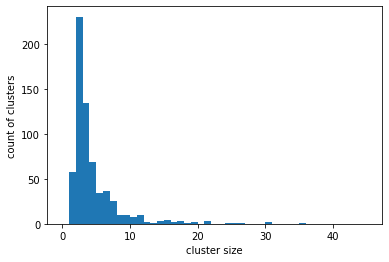

In [ ]:
counts = [count for count in dict(collections.Counter(clust_ids)).values()]
bins = np.array(range(0, max(counts)))
plt.hist(counts, bins=bins)
plt.xlabel("cluster size")
plt.ylabel("count of clusters")
plt.show()